In [1]:
import os
import sys

import numpy as np
import pandas as pd
import polars as pl

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

# Random Seeds
SEED=3093453
np.random.seed(SEED)
tf.random.set_seed(SEED)



# Cosmetics
np.set_printoptions(
    edgeitems=30,
    linewidth=100_000,
    suppress=True
    )

sns.set(
    context="talk",
    style="darkgrid"
)


cwd = os.getcwd()
cwd, _ = os.path.split(cwd)

In [2]:


df = pd.DataFrame(columns = ["Set", "Filename", "raw"])


#for Set in ["A", "B", "C"]:
for Set in ["X"]:
    path = os.path.join(cwd, "data", Set)
    for dirpath, dirnames, filenames in os.walk(path):
        filenames = sorted(filenames)
        for filename in filenames:
            if not filename.endswith(".out"):
                continue
            filepath = os.path.join(dirpath, filename)
            #print(filename)
            with open(filepath, "r") as f:
                raw_text = f.read()
            
            data = pd.DataFrame([[Set, filename[:-4], raw_text]], columns = ["Set", "Filename", "raw"])
            df = pd.concat([df, data])


#df = df[df.Filename.str.contains(r"[A-Z][A-Z]\d?\-\d{1,3}")]

df["Threshold"] = df["Filename"].str.extract("\-(\d*)").astype(float)
df["Instance"] = df["Filename"].str.split("-").str[0]
df = df.sort_values(["Set", "Filename"]).reset_index(drop=True)
df

,Set,Filename,raw,Threshold,Instance
0,X,AS,"cpu-bind=MASK - cn-0002, task 0 0 [2204321]:...",NaN,AS
1,X,AS-0,"cpu-bind=MASK - cn-0142, task 0 0 [3234793]:...",0.0,AS
2,X,AS-10,"cpu-bind=MASK - cn-0140, task 0 0 [3622505]:...",10.0,AS
3,X,AS-100,"cpu-bind=MASK - cn-0100, task 0 0 [3560115]:...",100.0,AS
4,X,AS-20,"cpu-bind=MASK - cn-0206, task 0 0 [2294212]:...",20.0,AS
...,...,...,...,...,...
1225,X,VA7-90-4,"cpu-bind=MASK - cn-0255, task 0 0 [140886]: ...",90.0,VA7
1226,X,VA7-90-5,"cpu-bind=MASK - cn-0198, task 0 0 [1901417]:...",90.0,VA7
1227,X,VA7-90-6,"cpu-bind=MASK - cn-0217, task 0 0 [1503285]:...",90.0,VA7
1228,X,VA7-90-7,"cpu-bind=MASK - cn-0255, task 0 0 [141114]: ...",90.0,VA7


In [3]:
df["finalObjective"] = df.raw.str.extract("Final Solution\nObjective;(\d*\.?\d?)\nTransportation cost;").astype(float)
df["finalTransportationCost"] = df.raw.str.extract("Final Solution\nObjective;\d*\.?\d?\nTransportation cost;(\d*\.?\d?)").astype(float)
df["finalInventoryCost"] = df.raw.str.extract(
    "Final Solution\nObjective;\d*\.?\d?\nTransportation cost;\d*\.?\d?\nInventory cost;(\d*\.?\d?)"
).astype(float)
df["Runtime"] = df.raw.str.extract(
    "Final Solution\nObjective;\d*\.?\d?\nTransportation cost;\d*\.?\d?\nInventory cost;\d*\.?\d?\nRuntime;(\d*\.?\d?)"
).astype(float)
#df["finalObjective"].hist()

In [4]:
num_LNS_iterations = df["raw"].str.extractall(r"LNS iteration (\d*)").astype(int).reset_index().groupby("level_0")[0].max()
#num_LNS_iterations.index.name=
num_LNS_iterations.name = "num_LNS_iter"
df = df.join(num_LNS_iterations)
df["num_LNS_iter"] = df["num_LNS_iter"].fillna(0).astype(int)

In [5]:
df

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter
0,X,AS,"cpu-bind=MASK - cn-0002, task 0 0 [2204321]:...",NaN,AS,2017343.0,1942200.0,75143.0,3590.9,3
1,X,AS-0,"cpu-bind=MASK - cn-0142, task 0 0 [3234793]:...",0.0,AS,2305859.0,2229900.0,75959.0,3591.8,1
2,X,AS-10,"cpu-bind=MASK - cn-0140, task 0 0 [3622505]:...",10.0,AS,2300706.0,2225100.0,75606.0,3593.2,1
3,X,AS-100,"cpu-bind=MASK - cn-0100, task 0 0 [3560115]:...",100.0,AS,1925257.0,1847700.0,77557.0,2651.3,17
4,X,AS-20,"cpu-bind=MASK - cn-0206, task 0 0 [2294212]:...",20.0,AS,2300060.0,2224200.0,75860.0,3591.4,1
...,...,...,...,...,...,...,...,...,...,...
1225,X,VA7-90-4,"cpu-bind=MASK - cn-0255, task 0 0 [140886]: ...",90.0,VA7,29109.0,24000.0,5109.0,6.0,0
1226,X,VA7-90-5,"cpu-bind=MASK - cn-0198, task 0 0 [1901417]:...",90.0,VA7,29109.0,24000.0,5109.0,6.3,0
1227,X,VA7-90-6,"cpu-bind=MASK - cn-0217, task 0 0 [1503285]:...",90.0,VA7,29109.0,24000.0,5109.0,6.3,0
1228,X,VA7-90-7,"cpu-bind=MASK - cn-0255, task 0 0 [141114]: ...",90.0,VA7,29109.0,24000.0,5109.0,5.9,0


In [6]:
reference_df = df[df.Threshold.isnull()].copy()
df = df[~df.Threshold.isnull()].copy().reset_index(drop=True)
df["Threshold"] = df["Threshold"].astype(int)
df

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter
0,X,AS-0,"cpu-bind=MASK - cn-0142, task 0 0 [3234793]:...",0,AS,2305859.0,2229900.0,75959.0,3591.8,1
1,X,AS-10,"cpu-bind=MASK - cn-0140, task 0 0 [3622505]:...",10,AS,2300706.0,2225100.0,75606.0,3593.2,1
2,X,AS-100,"cpu-bind=MASK - cn-0100, task 0 0 [3560115]:...",100,AS,1925257.0,1847700.0,77557.0,2651.3,17
3,X,AS-20,"cpu-bind=MASK - cn-0206, task 0 0 [2294212]:...",20,AS,2300060.0,2224200.0,75860.0,3591.4,1
4,X,AS-30,"cpu-bind=MASK - cn-0206, task 0 0 [2294211]:...",30,AS,1922034.0,1844700.0,77334.0,2576.1,10
...,...,...,...,...,...,...,...,...,...,...
1120,X,VA7-90-4,"cpu-bind=MASK - cn-0255, task 0 0 [140886]: ...",90,VA7,29109.0,24000.0,5109.0,6.0,0
1121,X,VA7-90-5,"cpu-bind=MASK - cn-0198, task 0 0 [1901417]:...",90,VA7,29109.0,24000.0,5109.0,6.3,0
1122,X,VA7-90-6,"cpu-bind=MASK - cn-0217, task 0 0 [1503285]:...",90,VA7,29109.0,24000.0,5109.0,6.3,0
1123,X,VA7-90-7,"cpu-bind=MASK - cn-0255, task 0 0 [141114]: ...",90,VA7,29109.0,24000.0,5109.0,5.9,0


In [7]:
reference_df

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter
0,X,AS,"cpu-bind=MASK - cn-0002, task 0 0 [2204321]:...",NaN,AS,2017343.0,1942200.0,75143.0,3590.9,3
12,X,AS2,"cpu-bind=MASK - cn-0256, task 0 0 [978147]: ...",NaN,AS2,2173535.0,2043600.0,129935.0,3595.7,3
24,X,AS3,"cpu-bind=MASK - cn-0214, task 0 0 [2414625]:...",NaN,AS3,9809539.0,9706500.0,103039.0,3597.4,3
36,X,AS4,"cpu-bind=MASK - cn-0245, task 0 0 [3948989]:...",NaN,AS4,2048455.0,1975500.0,72955.0,3596.1,3
48,X,AS5,"cpu-bind=MASK - cn-0202, task 0 0 [588995]: ...",NaN,AS5,2217620.0,2084700.0,132920.0,3594.9,3
...,...,...,...,...,...,...,...,...,...,...
1172,X,VA3,"cpu-bind=MASK - cn-0014, task 0 0 [1643472]:...",NaN,VA3,120032.0,105000.0,15032.0,29.6,0
1184,X,VA4,"cpu-bind=MASK - cn-0049, task 0 0 [1727902]:...",NaN,VA4,29709.0,24600.0,5109.0,6.4,0
1196,X,VA5,"cpu-bind=MASK - cn-0056, task 0 0 [3451343]:...",NaN,VA5,36755.0,32100.0,4655.0,4.7,0
1208,X,VA6,"cpu-bind=MASK - cn-0129, task 0 0 [110430]: ...",NaN,VA6,119026.0,106500.0,12526.0,7.9,0


In [8]:
df = df.merge(
    reference_df[["Set", "Instance", "finalTransportationCost", "finalInventoryCost", "finalObjective", "Runtime", "num_LNS_iter"]],
    how="left",
    on=["Set", "Instance"],
    suffixes=("", "_Reference"),
    
)
df

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter,finalTransportationCost_Reference,finalInventoryCost_Reference,finalObjective_Reference,Runtime_Reference,num_LNS_iter_Reference
0,X,AS-0,"cpu-bind=MASK - cn-0142, task 0 0 [3234793]:...",0,AS,2305859.0,2229900.0,75959.0,3591.8,1,1942200.0,75143.0,2017343.0,3590.9,3
1,X,AS-10,"cpu-bind=MASK - cn-0140, task 0 0 [3622505]:...",10,AS,2300706.0,2225100.0,75606.0,3593.2,1,1942200.0,75143.0,2017343.0,3590.9,3
2,X,AS-100,"cpu-bind=MASK - cn-0100, task 0 0 [3560115]:...",100,AS,1925257.0,1847700.0,77557.0,2651.3,17,1942200.0,75143.0,2017343.0,3590.9,3
3,X,AS-20,"cpu-bind=MASK - cn-0206, task 0 0 [2294212]:...",20,AS,2300060.0,2224200.0,75860.0,3591.4,1,1942200.0,75143.0,2017343.0,3590.9,3
4,X,AS-30,"cpu-bind=MASK - cn-0206, task 0 0 [2294211]:...",30,AS,1922034.0,1844700.0,77334.0,2576.1,10,1942200.0,75143.0,2017343.0,3590.9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,X,VA7-90-4,"cpu-bind=MASK - cn-0255, task 0 0 [140886]: ...",90,VA7,29109.0,24000.0,5109.0,6.0,0,24000.0,5109.0,29109.0,6.4,0
1121,X,VA7-90-5,"cpu-bind=MASK - cn-0198, task 0 0 [1901417]:...",90,VA7,29109.0,24000.0,5109.0,6.3,0,24000.0,5109.0,29109.0,6.4,0
1122,X,VA7-90-6,"cpu-bind=MASK - cn-0217, task 0 0 [1503285]:...",90,VA7,29109.0,24000.0,5109.0,6.3,0,24000.0,5109.0,29109.0,6.4,0
1123,X,VA7-90-7,"cpu-bind=MASK - cn-0255, task 0 0 [141114]: ...",90,VA7,29109.0,24000.0,5109.0,5.9,0,24000.0,5109.0,29109.0,6.4,0


In [9]:
df["Subset"] = "Training"
df.loc[(df.Set == "X") & (df.Instance.str.endswith("4") | df.Instance.str.endswith("5")), "Subset"] = "Validation"
df.loc[(df.Set == "X") & (df.Instance.str.endswith("6") | df.Instance.str.endswith("7")), "Subset"] = "Testing"

In [10]:
df = df[(df["Subset"] == "Testing")]

In [11]:
clms = df.columns

for clm in clms[clms.str.contains("_Reference")]:
    clm_clean = clm.split("_Reference")[0]
    df[clm_clean] = df[clm_clean] / df[clm]

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_54746/2554790196.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[clm_clean] = df[clm_clean] / df[clm]


In [12]:
df

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter,finalTransportationCost_Reference,finalInventoryCost_Reference,finalObjective_Reference,Runtime_Reference,num_LNS_iter_Reference,Subset
55,X,AS6-90,"cpu-bind=MASK - cn-0058, task 0 0 [3145857]:...",90,AS6,0.953500,0.953432,0.959382,0.799236,4.000000,9856500.0,115170.0,9971670.0,3455.8,3,Testing
56,X,AS6-90-0,"cpu-bind=MASK - cn-0106, task 0 0 [3461650]:...",90,AS6,0.946129,0.945823,0.972345,0.775537,4.000000,9856500.0,115170.0,9971670.0,3455.8,3,Testing
57,X,AS6-90-1,"cpu-bind=MASK - cn-0106, task 0 0 [3461625]:...",90,AS6,0.942477,0.942170,0.968724,0.762313,3.666667,9856500.0,115170.0,9971670.0,3455.8,3,Testing
58,X,AS6-90-2,"cpu-bind=MASK - cn-0106, task 0 0 [3461626]:...",90,AS6,0.946588,0.946127,0.986064,0.791770,4.666667,9856500.0,115170.0,9971670.0,3455.8,3,Testing
59,X,AS6-90-3,"cpu-bind=MASK - cn-0107, task 0 0 [2891141]:...",90,AS6,0.942287,0.941714,0.991352,0.788298,4.666667,9856500.0,115170.0,9971670.0,3455.8,3,Testing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,X,VA7-90-4,"cpu-bind=MASK - cn-0255, task 0 0 [140886]: ...",90,VA7,1.000000,1.000000,1.000000,0.937500,NaN,24000.0,5109.0,29109.0,6.4,0,Testing
1121,X,VA7-90-5,"cpu-bind=MASK - cn-0198, task 0 0 [1901417]:...",90,VA7,1.000000,1.000000,1.000000,0.984375,NaN,24000.0,5109.0,29109.0,6.4,0,Testing
1122,X,VA7-90-6,"cpu-bind=MASK - cn-0217, task 0 0 [1503285]:...",90,VA7,1.000000,1.000000,1.000000,0.984375,NaN,24000.0,5109.0,29109.0,6.4,0,Testing
1123,X,VA7-90-7,"cpu-bind=MASK - cn-0255, task 0 0 [141114]: ...",90,VA7,1.000000,1.000000,1.000000,0.921875,NaN,24000.0,5109.0,29109.0,6.4,0,Testing


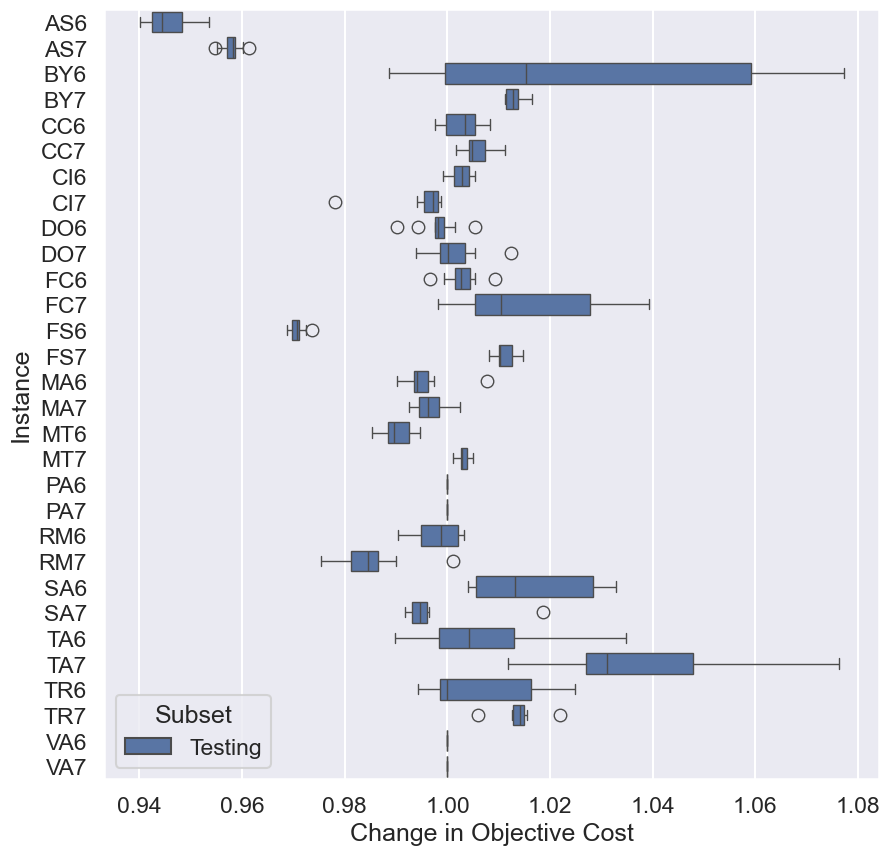

In [13]:
plt.figure(figsize=(10, 10))
#sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Set");
sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Subset");
plt.xlabel("Change in Objective Cost");

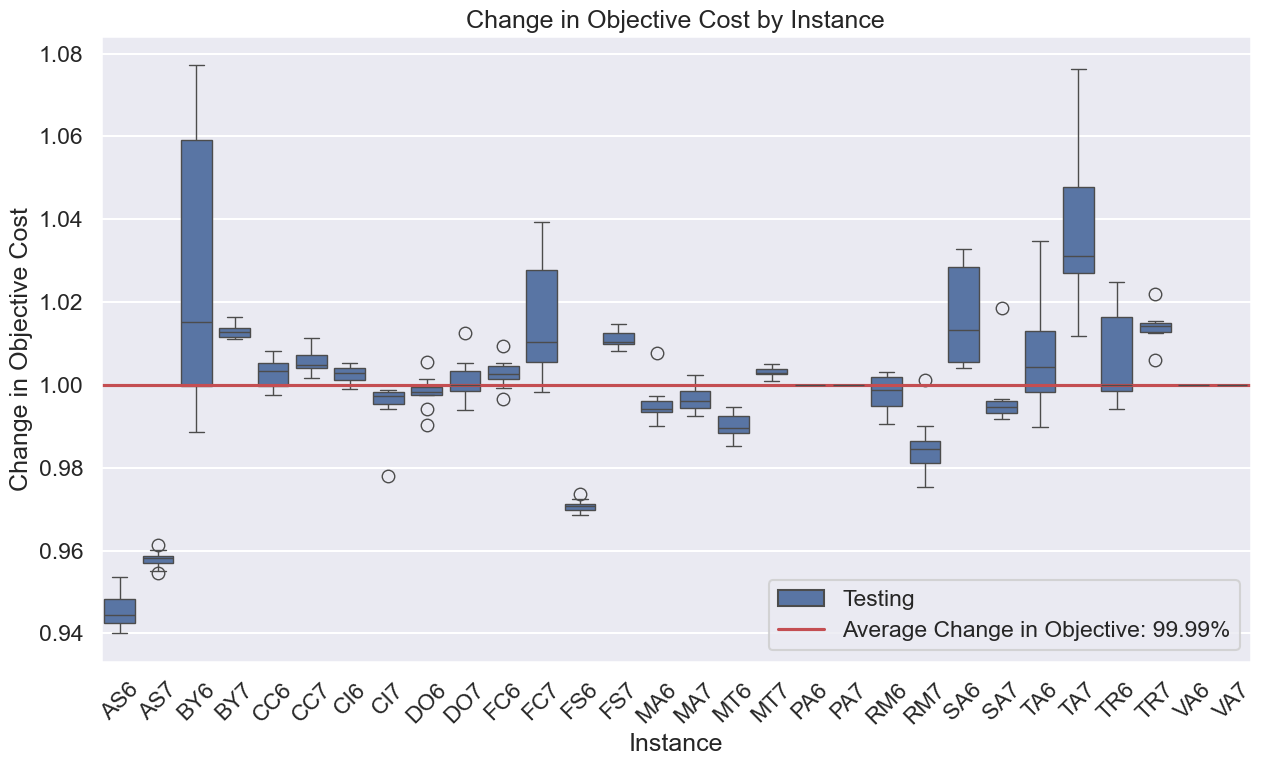

In [359]:
plt.figure(figsize=(13, 8))
#sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Set");
sns.boxplot(data=df, x="Instance", y="finalObjective", hue="Subset");
plt.axhline(df["finalObjective"].mean(), c="r", label=f"Average Change in Objective: {df.finalObjective.mean():.2%}")
plt.ylabel("Change in Objective Cost");
plt.title("Change in Objective Cost by Instance");
plt.xticks(rotation=45);
plt.legend()

plt.tight_layout()
for file_format in ["png", "jpg", "pdf", "svg"]:
    path = os.path.join(cwd, "plots", "2024-02-14-ExperimentsThreshold", f"Change in Objective by Instance TESTING.{file_format}")
    plt.savefig(path)


In [340]:
help(df.melt)

Help on method melt in module pandas.core.frame:

melt(id_vars=None, value_vars=None, var_name=None, value_name: 'Hashable' = 'value', col_level: 'Level | None' = None, ignore_index: 'bool' = True) -> 'DataFrame' method of pandas.core.frame.DataFrame instance
    Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.
    
    This function is useful to massage a DataFrame into a format where one
    or more columns are identifier variables (`id_vars`), while all other
    columns, considered measured variables (`value_vars`), are "unpivoted" to
    the row axis, leaving just two non-identifier columns, 'variable' and
    'value'.
    
    Parameters
    ----------
    id_vars : tuple, list, or ndarray, optional
        Column(s) to use as identifier variables.
    value_vars : tuple, list, or ndarray, optional
        Column(s) to unpivot. If not specified, uses all columns that
        are not set as `id_vars`.
    var_name : scalar
        Name to use for t

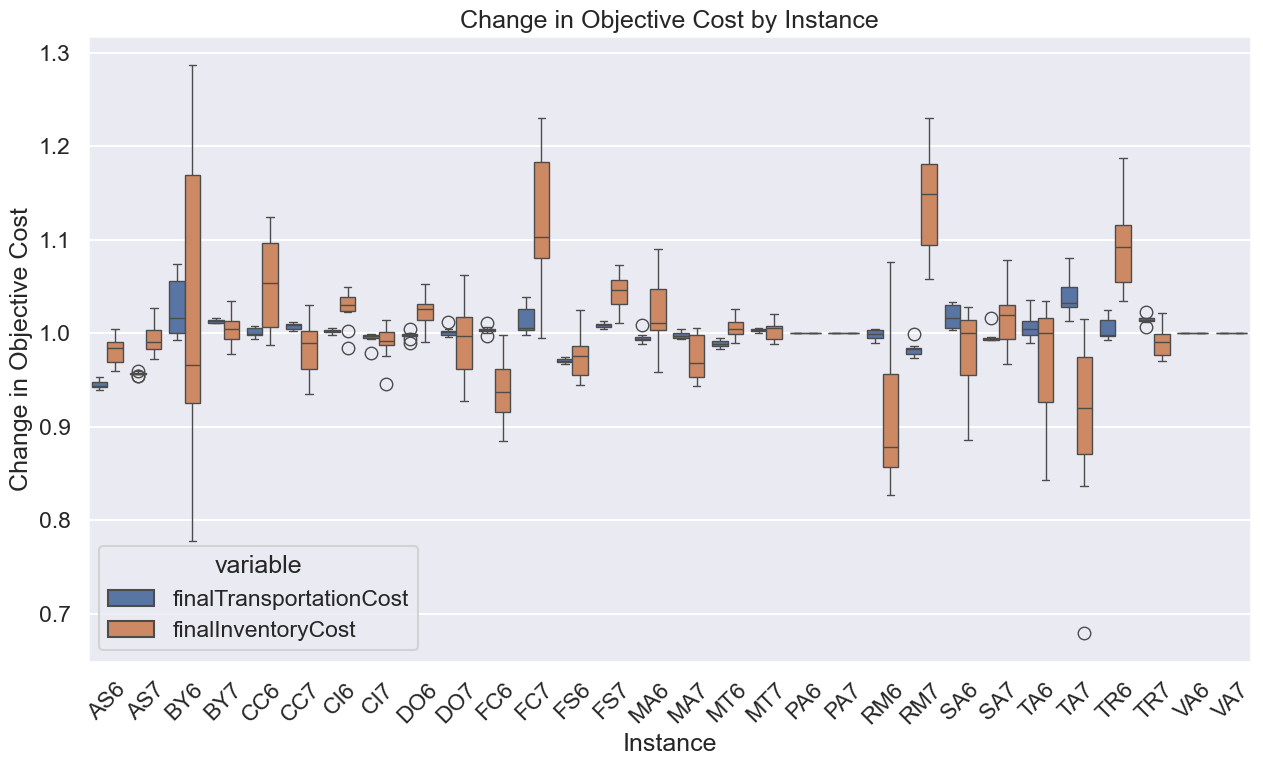

In [352]:
plt.figure(figsize=(13, 8))
#sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Set");
#sns.boxplot(data=df, x="Instance", y="finalObjective", hue="Subset");
sns.boxplot(df.melt(id_vars=["Instance"],
                    value_vars=[#"finalObjective",
                                "finalTransportationCost", "finalInventoryCost"]
                   ),
            x="Instance",
            y="value",
            hue="variable"
);

plt.ylabel("Change in Objective Cost");
plt.title("Change in Objective Cost by Instance");
plt.xticks(rotation=45);

plt.tight_layout()
#for file_format in ["png", "jpg", "pdf", "svg"]:
#    path = os.path.join(cwd, "plots", "2024-02-14-ExperimentsThreshold", f"Change in Objective by Instance TESTING.{file_format}")
#    plt.savefig(path)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 55 to 1124
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Set                                300 non-null    object 
 1   Filename                           300 non-null    object 
 2   raw                                300 non-null    object 
 3   Threshold                          300 non-null    int64  
 4   Instance                           300 non-null    object 
 5   finalObjective                     300 non-null    float64
 6   finalTransportationCost            300 non-null    float64
 7   finalInventoryCost                 300 non-null    float64
 8   Runtime                            300 non-null    float64
 9   num_LNS_iter                       280 non-null    float64
 10  finalTransportationCost_Reference  300 non-null    float64
 11  finalInventoryCost_Reference       300 non-null    float64
 1

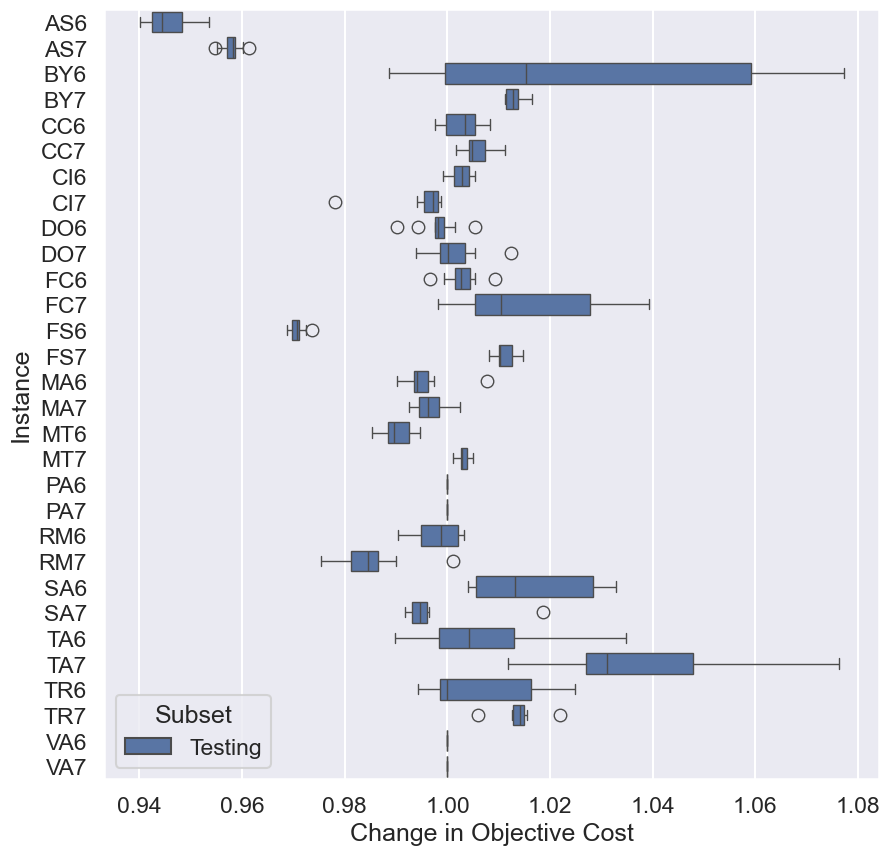

In [17]:
plt.figure(figsize=(10, 10))
#sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Set");
sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Subset");
plt.xlabel("Change in Objective Cost");

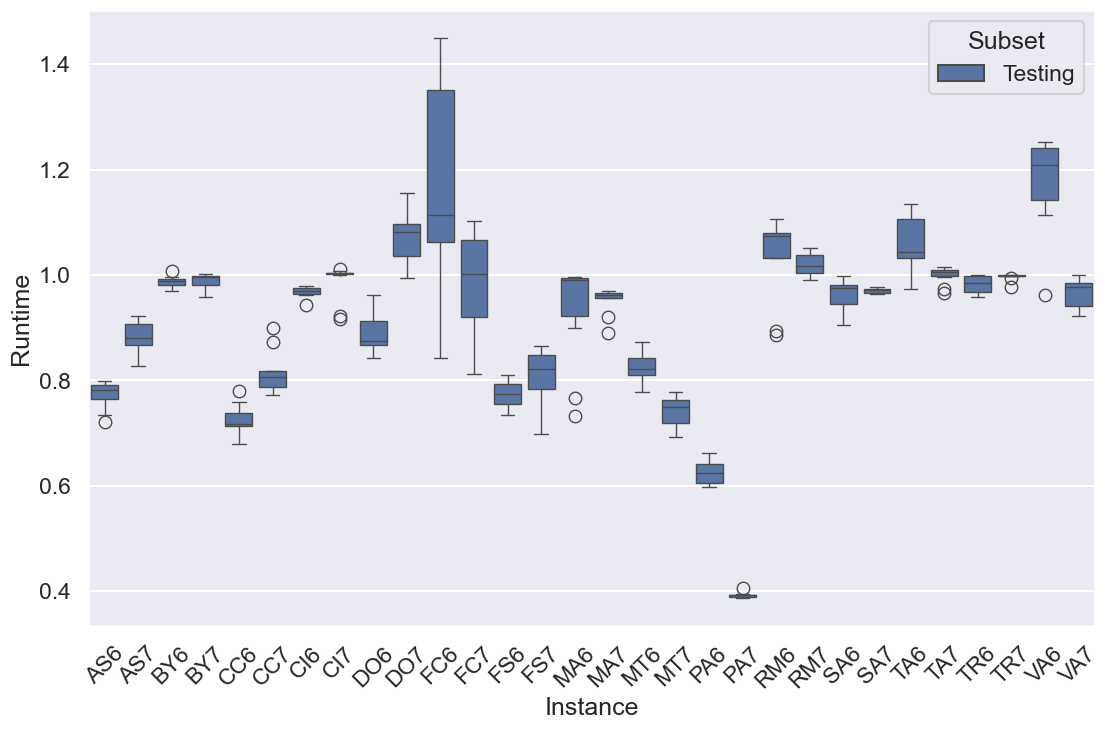

In [241]:
plt.figure(figsize=(13, 8))
#sns.boxplot(data=df, y="Instance", x="finalObjective", hue="Set");
sns.boxplot(data=df, x="Instance", y="Runtime", hue="Subset");
plt.xticks(rotation=45);
#sns.boxplot(data=df, y="Instance", x="Runtime", hue="Subset");
#plt.xlabel("Change in Runtime [lower is better]");

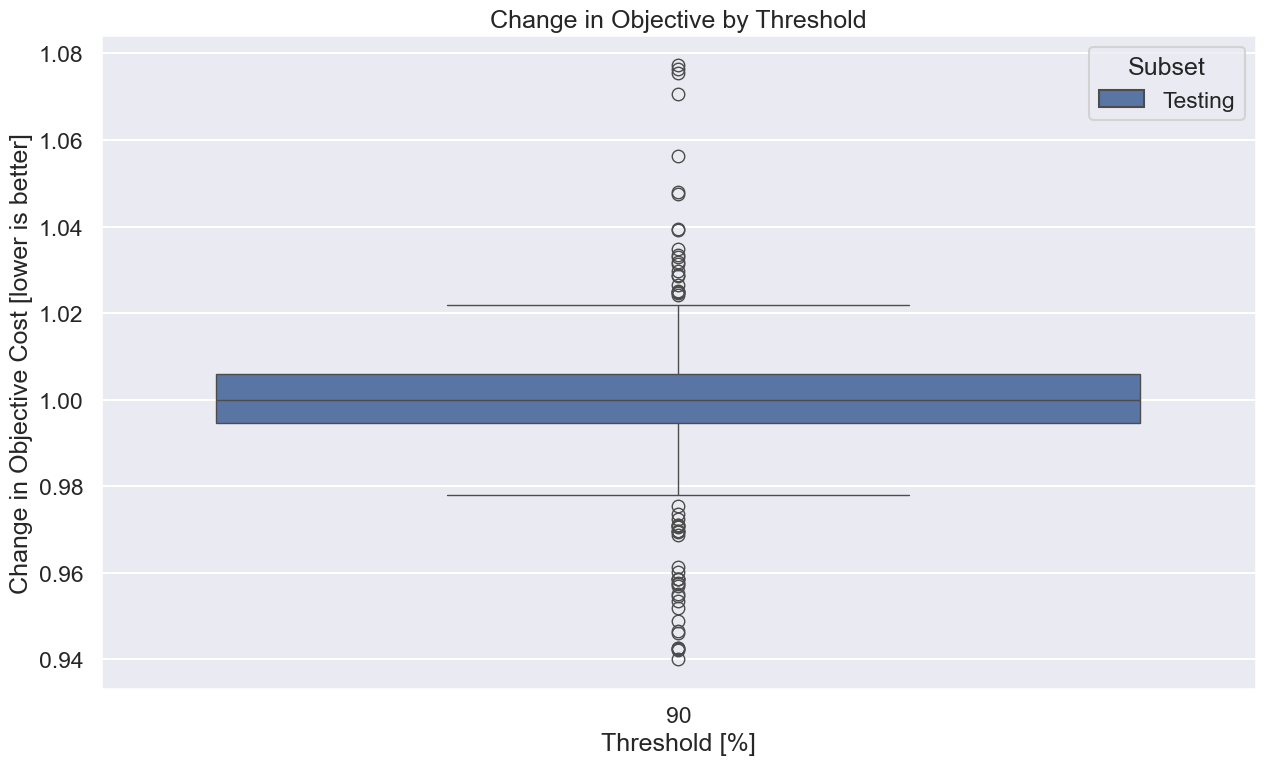

In [18]:
plt.figure(figsize=(13, 8))
sns.boxplot(data=df, y="finalObjective", x="Threshold", hue="Subset");
plt.xlabel("Threshold [%]")
plt.ylabel("Change in Objective Cost [lower is better]");
plt.title("Change in Objective by Threshold")

plt.tight_layout()
for file_format in ["png", "jpg", "pdf", "svg"]:
    path = os.path.join(cwd, "plots", "2024-02-14-ExperimentsThreshold", f"Change in Objective by Threshold TESTING.{file_format}")
    plt.savefig(path)


In [19]:
x = df.finalObjective[df.Threshold == 90]
x = x[~x.isnull()]

t_value = (1-x.mean()) / x.std() * len(x)**0.5
t_value

0.12057050666377747

In [20]:
from scipy.stats import t

t.pdf(t_value, df=len(x)-1)

0.39571247365420725

In [297]:
df["num_LNS_iter"]

55      4.000000
56      4.000000
57      3.666667
58      4.666667
59      4.666667
          ...   
1120         NaN
1121         NaN
1122         NaN
1123         NaN
1124         NaN
Name: num_LNS_iter, Length: 300, dtype: float64

In [316]:
from scipy.stats import norm, ttest_1samp

print(ttest_1samp(df["Runtime"], 1))
print(ttest_1samp(df["num_LNS_iter"], 1, nan_policy="omit"))

TtestResult(statistic=-8.793806846578187, pvalue=1.1669708866746273e-16, df=299)
TtestResult(statistic=14.826292483655255, pvalue=4.502911542616563e-37, df=279)


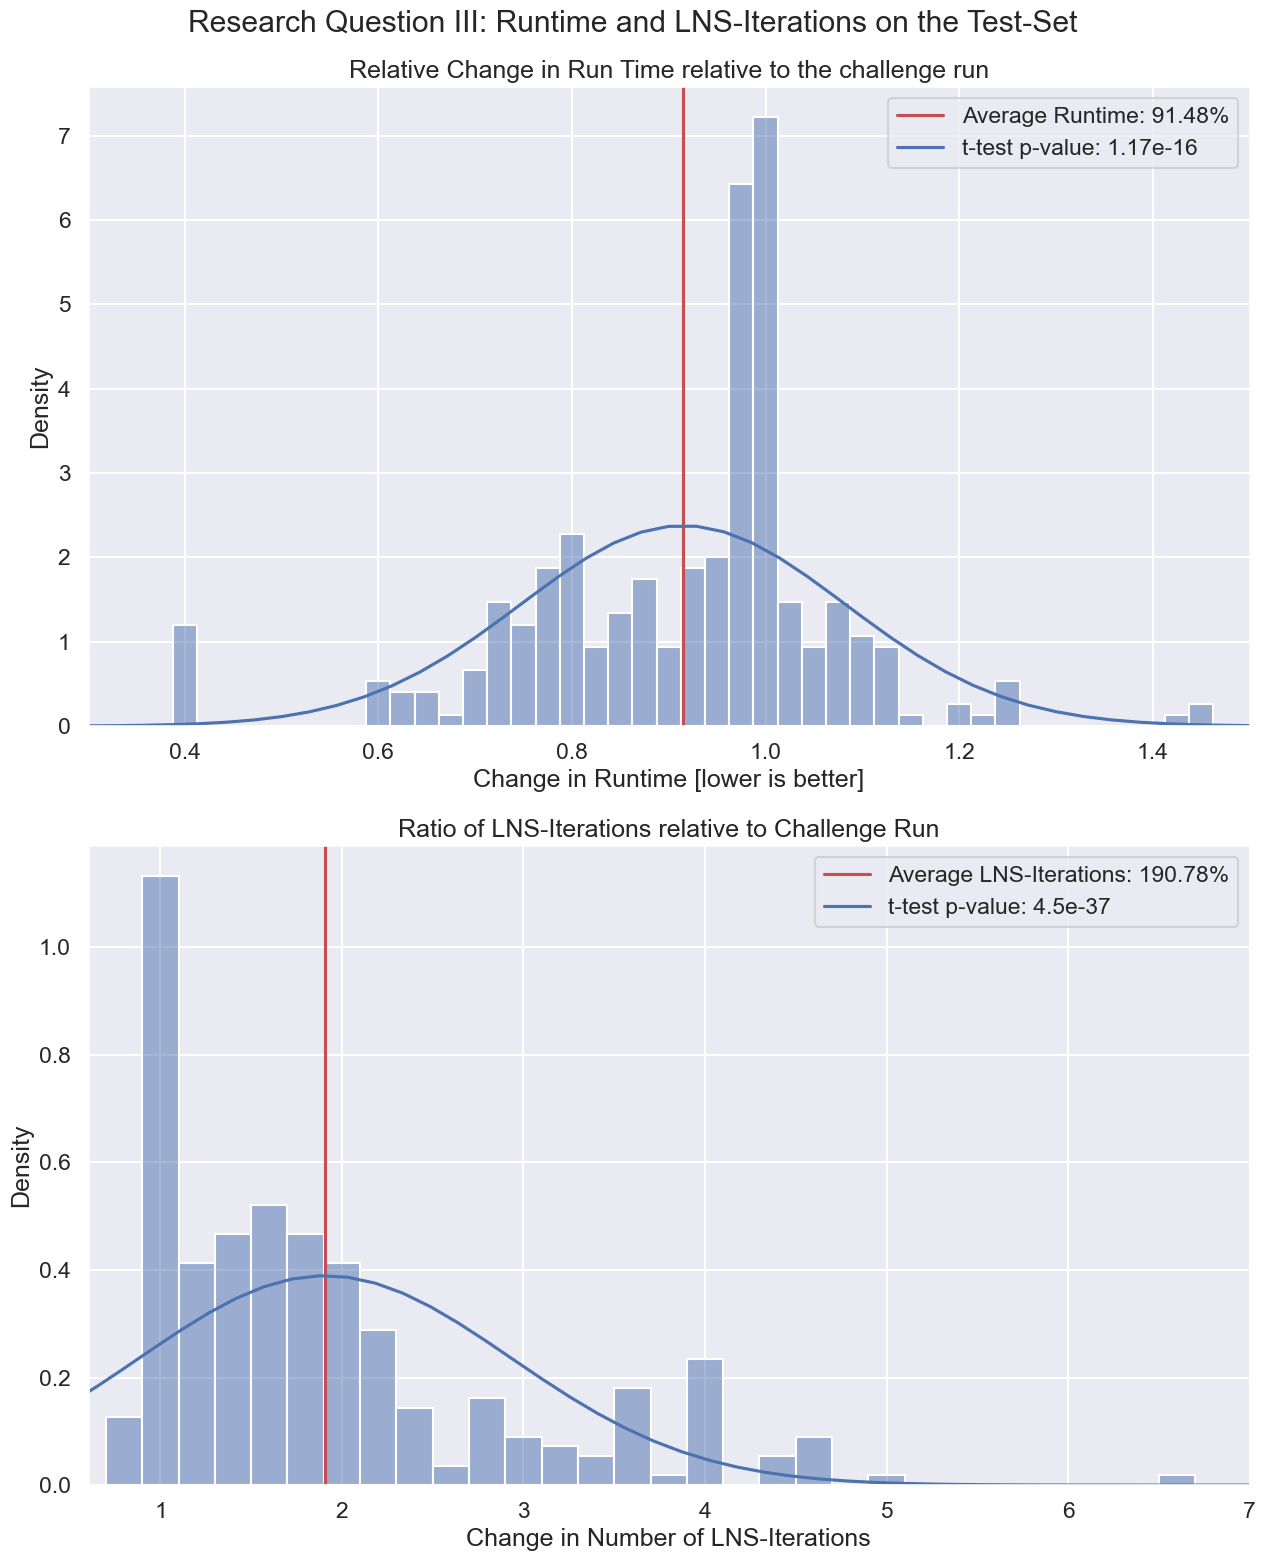

In [329]:
from scipy.stats import norm, ttest_1samp

fig, ax = plt.subplots(2, figsize=(13, 16))

mu, sd = df["Runtime"].mean(), df["Runtime"].std()
dist = norm(mu, sd)
xx = np.linspace(0.3, 1.7)
yy = dist.pdf(xx)
sns.histplot(
    data=df, x="Runtime", hue="Subset", stat="density",
    bins=np.arange(0.4, 1.5, 0.025)-0.025/2,
    ax=ax[0]
);
#sns.kdeplot(data=df, x="Runtime", hue="Subset",ax=ax[0]);
ax[0].axvline(mu, c="r", label=f"Average Runtime: {mu:.2%}")
ax[0].plot(xx, yy, label=f"t-test p-value: 1.17e-16")

ax[0].set(
    #xlabel="Threshold [%]",
    xlabel="Change in Runtime [lower is better]",
    title="Relative Change in Run Time relative to the challenge run",
    xlim=[0.3, 1.5]
)
ax[0].legend()




mu, sd = df["num_LNS_iter"].mean(), df["num_LNS_iter"].std()
dist = norm(mu, sd)
xx = np.linspace(0.5, 8)
yy = dist.pdf(xx)

sns.histplot(
    data=df, x="num_LNS_iter", hue="Subset", stat="density",
    bins=np.arange(0.8, 7, 0.2)-0.1,
    ax=ax[1]
);
ax[1].axvline(mu, c="r", label=f"Average LNS-Iterations: {mu:.2%}")
ax[1].plot(xx, yy, label=f"t-test p-value: 4.5e-37")

ax[1].set(
    xlabel="Change in Number of LNS-Iterations",
    title="Ratio of LNS-Iterations relative to Challenge Run",
    xlim=[0.6, 7]
)
ax[1].legend()

fig.suptitle("Research Question III: Runtime and LNS-Iterations on the Test-Set")
fig.tight_layout()
for file_format in ["png", "jpg", "pdf", "svg"]:
    path = os.path.join(cwd, "plots", "2024-02-14-ExperimentsThreshold", f"Change in Runtime TESTING.{file_format}")
    plt.savefig(path)

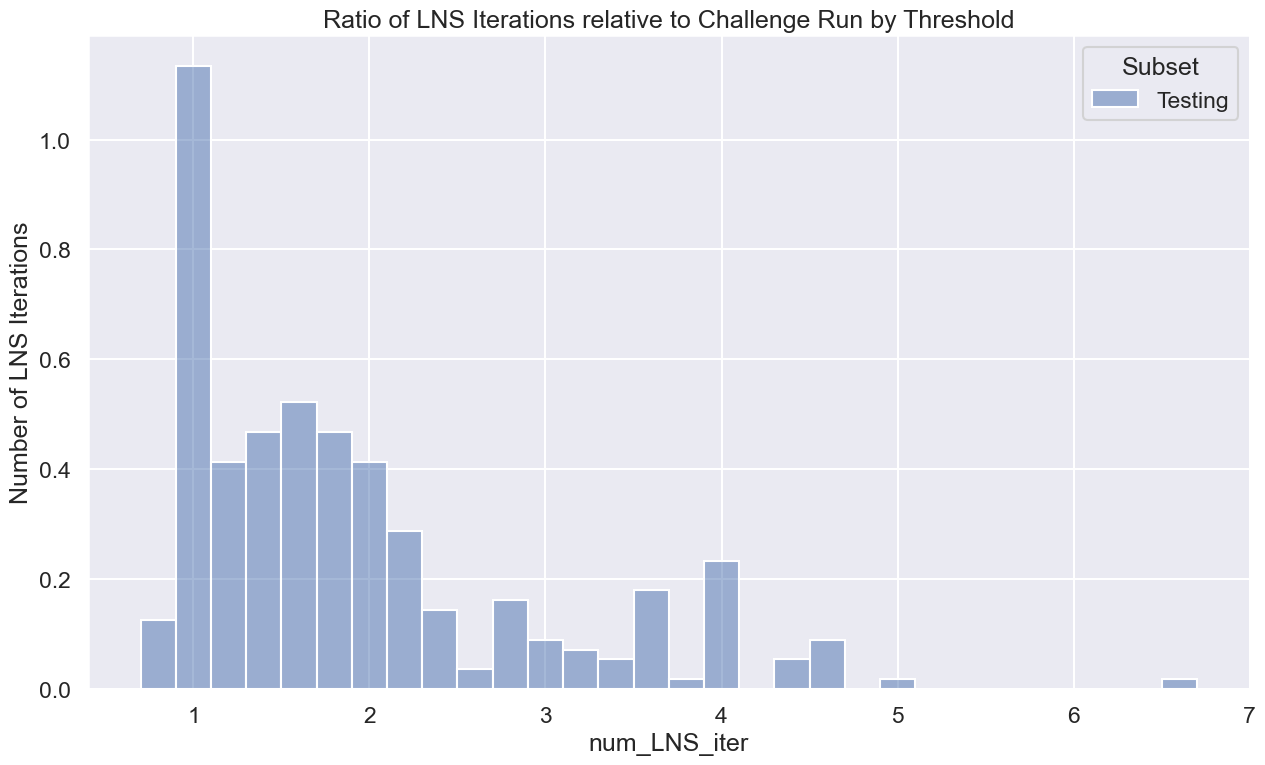

In [264]:
plt.figure(figsize=(13, 8))
sns.histplot(
    data=df, x="num_LNS_iter", hue="Subset", stat="density",
    bins=np.arange(0.8, 7, 0.2)-0.1
);
plt.ylabel("Number of LNS Iterations");
plt.title("Ratio of LNS Iterations relative to Challenge Run by Threshold");
plt.tight_layout()

In [326]:
df.loc[df["num_LNS_iter"].isnull(), "Instance"].value_counts()

Instance
VA6    10
VA7    10
Name: count, dtype: int64

In [23]:
reference_df[(reference_df.Set == "A")&(reference_df.Instance == "BU")]

,Set,Filename,raw,Threshold,Instance,finalObjective,finalTransportationCost,finalInventoryCost,Runtime,num_LNS_iter


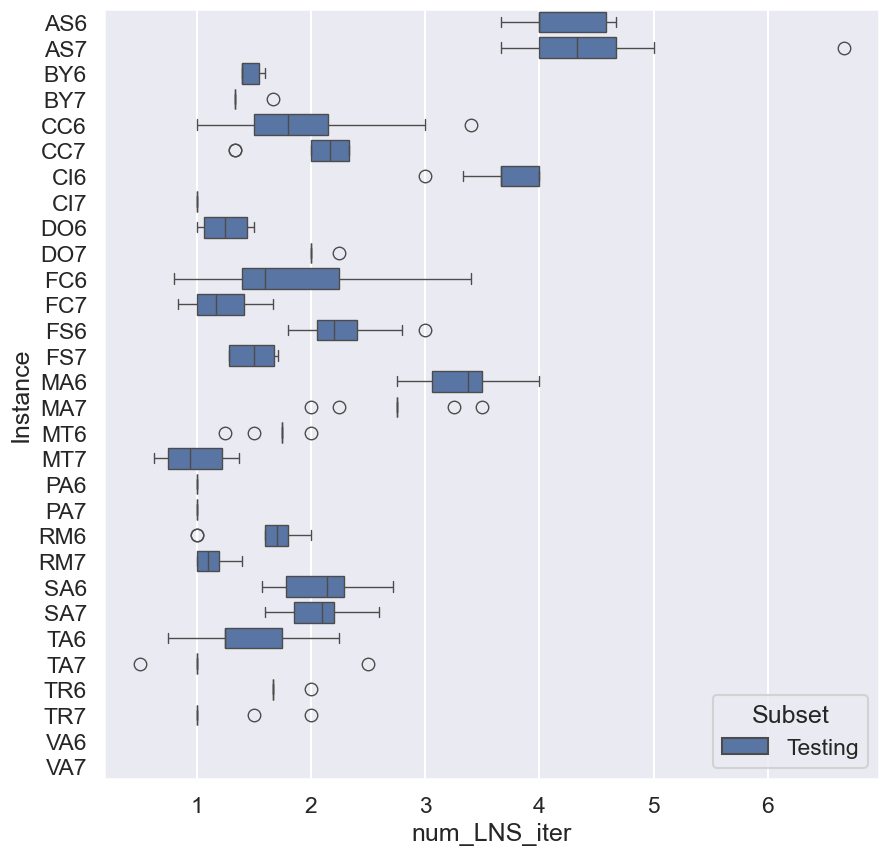

In [24]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df, y="Instance", x="num_LNS_iter", hue="Subset");
#plt.ylabel("Change in Runtime");

In [29]:
print(df.loc[55, "raw"])

# Time spent for prediction: 0.2593917641788721 for Batch of 311 truck plans
# Time spent for prediction: 0.13098688796162605 for Batch of 109 truck plans

cpu-bind=MASK - cn-0058, task  0  0 [3145857]: mask |BBBBBBBB------------||||--------------------|  set
Not a conda environment: /pc2/users/d/dwetzel/.conda/envs/ROADEF
Python 3.9.12
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)
Copyright (c) 2022, Gurobi Optimization, LLC
started at Sat Feb 17 12:50:10 CET 2024
2024-02-17 12:50:11.450574: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-17 12:50:11.489294: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 12:50:11.489360: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 12:50:11.489404: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register c

In [72]:
predictions_df = df.raw.str.extractall(r"Time spent for prediction: (\d*\.\d*) for Batch of (\d*) truck plans")
predictions_df.columns = ["time", "batch_size"]
predictions_df = predictions_df.astype({
    "time": float,
    "batch_size": int
})
predictions_df = predictions_df.reset_index("match")
predictions_df = predictions_df.join(df["Instance"])
predictions_df

,match,time,batch_size,Instance
55,0,0.259392,311,AS6
55,1,0.130987,109,AS6
55,2,0.114443,67,AS6
55,3,0.102613,47,AS6
55,4,0.089708,20,AS6
...,...,...,...,...
1048,1,0.191559,224,TR7
1048,2,0.168671,155,TR7
1049,0,0.337588,402,TR7
1049,1,0.176040,210,TR7


In [310]:
from sklearn.linear_model import LinearRegression, HuberRegressor

reg = HuberRegressor()
reg = reg.fit(predictions_df[["batch_size"]], predictions_df["time"])


ß0, ß1 = reg.intercept_, reg.coef_
xx = np.array([np.arange(0, 800)]).T
yy = reg.predict(xx)

/Users/fynn/Uni/MA/.venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but HuberRegressor was fitted with feature names
  warnings.warn(


In [313]:
subset = predictions_df[(predictions_df["time"] > 1) | (predictions_df["batch_size"] > 350)]
subset.groupby("Instance").median()

,match,time,batch_size
Instance,,,
AS7,0.0,16.564992,229.0
BY6,0.0,0.335268,486.5
BY7,0.0,0.352947,615.5
CC6,0.0,2.256349,132.0
CC7,0.0,2.753963,97.0
CI6,0.0,19.307034,204.5
CI7,0.0,23.100772,189.0
DO7,0.0,2.824608,128.0
FC6,0.0,3.338617,77.0


/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_54746/2098259769.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(


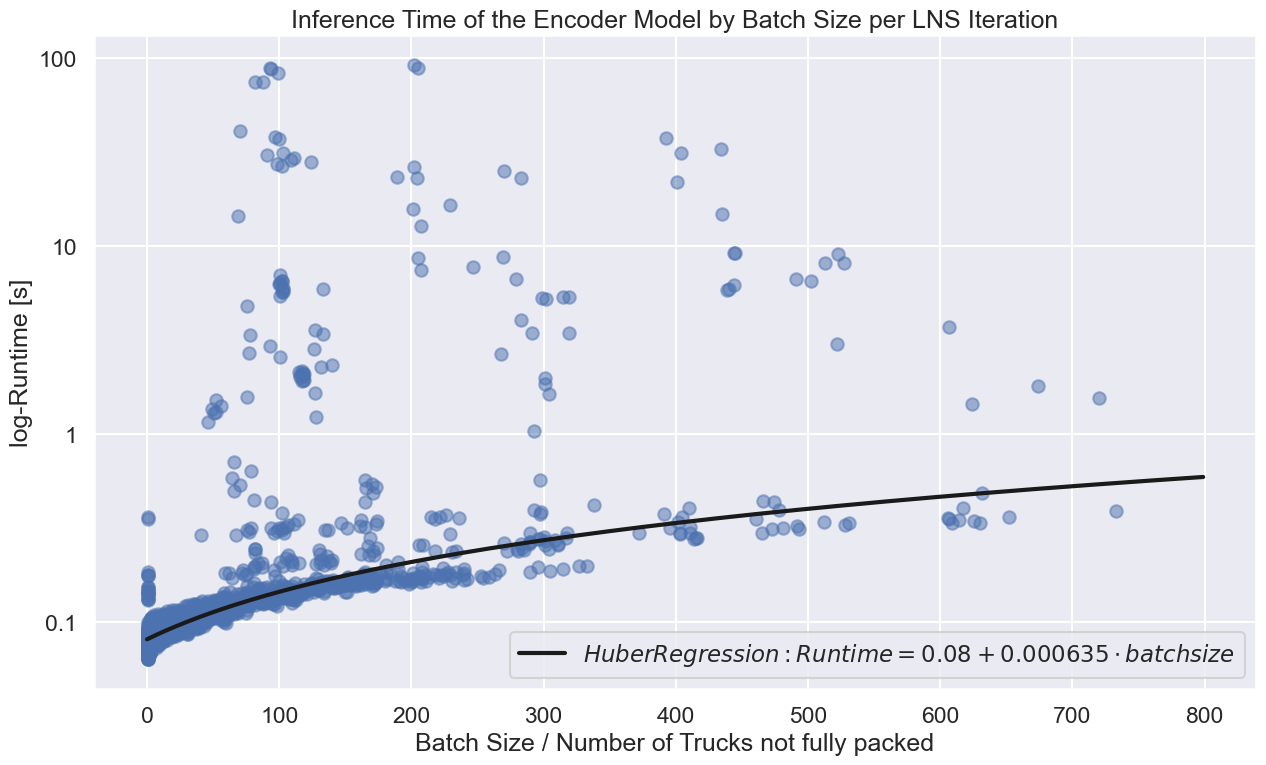

In [315]:
fig, ax=plt.subplots(figsize=(13, 8))

ax.scatter(
    x=predictions_df["batch_size"],
    y=predictions_df["time"],
    #hue="Instance",
    alpha=0.5,
    #color=["r" for _ in predictions_df["batch_size"]]
    #ax=ax,
);
ax.plot(
    xx,
    yy,
    lw=3,
    c="k",
    label=f"$Huber Regression: Runtime={ß0:.2f}+{ß1[0]:.6f} \cdot batch size$"
)
ax.legend(loc="lower right");

#sns.scatterplot(
#    data=subset,
#    x="batch_size",
#    y="time",
#    hue="Instance"
#)
#for i, row in subset.groupby("Instance").median().iterrows():
#    ax.annotate(row.name, (row.batch_size, row.time))



y_labels = [f"{10**i}"for i in range(-3, 4)]
#ax.set_yticklabels(labels);

ax.set(
    yscale="log",
    yticklabels=y_labels,
    ylabel="log-Runtime [s]",
    xlabel="Batch Size / Number of Trucks not fully packed",
    title="Inference Time of the Encoder Model by Batch Size per LNS Iteration",
    #xlim=[-1, 1000]
);

plt.tight_layout()
path = os.path.join(cwd, "plots", "2024-02-14-ExperimentsThreshold", f"InferenceTime by BatchSize.pdf")
plt.savefig(path)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_54746/2583966329.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(


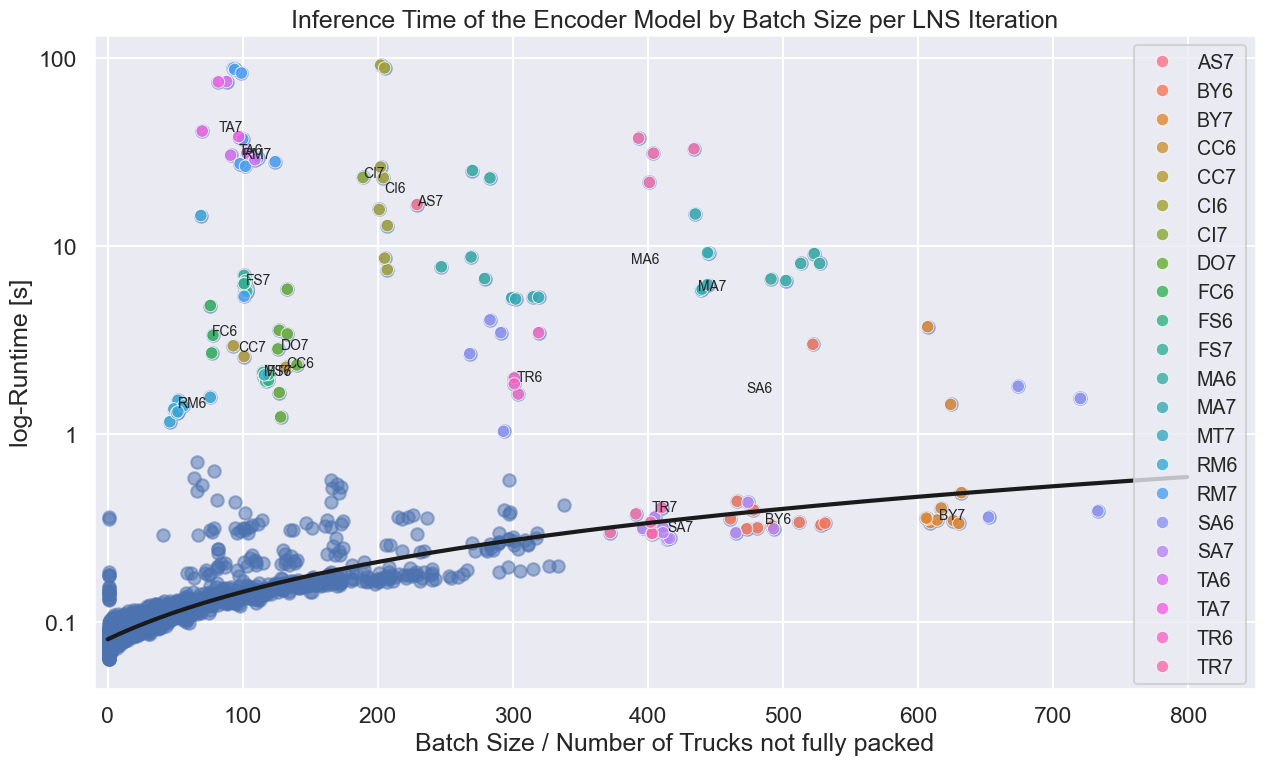

In [229]:
fig, ax=plt.subplots(figsize=(13, 8))

ax.scatter(
    x=predictions_df["batch_size"],
    y=predictions_df["time"],
    #hue="Instance",
    alpha=0.5,
    #color=["r" for _ in predictions_df["batch_size"]]
    #ax=ax,
);
ax.plot(
    xx,
    yy,
    lw=3,
    c="k",
    #label=f"$MAE-Regression: {ß0:.2f}+{ß1[0]:.6f} \cdot batch size$"
)
ax.legend(loc="lower right");

sns.scatterplot(
    data=subset,
    x="batch_size",
    y="time",
    hue="Instance",
    alpha=0.8
)
for i, row in subset.groupby("Instance").median().iterrows():
    ax.annotate(row.name, (row.batch_size, row.time), fontsize=10)



y_labels = [f"{10**i}"for i in range(-3, 4)]


ax.set(
    yscale="log",
    yticklabels=y_labels,
    ylabel="log-Runtime [s]",
    xlabel="Batch Size / Number of Trucks not fully packed",
    title="Inference Time of the Encoder Model by Batch Size per LNS Iteration",
    xlim=[-10, 850]
);

ax.legend(fontsize=14.1)
plt.tight_layout()
path = os.path.join(cwd, "plots", "2024-02-14-ExperimentsThreshold", f"InferenceTime by BatchSize-OUTLIERS.pdf")
plt.savefig(path)